In [1]:
#                       _oo0oo_
#                      o8888888o
#                      88" . "88
#                      (| -_- |)
#                      0\  =  /0
#                    ___/`---'\___
#                  .' \\|     |# '.
#                 / \\|||  :  |||# \
#                / _||||| -:- |||||- \
#               |   | \\\  -  #/ |   |
#               | \_|  ''\---/''  |_/ |
#               \  .-\__  '-'  ___/-. /
#             ___'. .'  /--.--\  `. .'___
#          ."" '<  `.___\_<|>_/___.' >' "".
#         | | :  `- \`.;`\ _ /`;.`/ - ` : | |
#         \  \ `_.   \_ __\ /__ _/   .-` /  /
#     =====`-.____`.___ \_____/___.-`___.-'=====
#                       `=---='
#
#
#     ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
#               佛祖保佑         永无BUG

In [2]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1'
os.environ["VECLIB_MAXIMUM_THREADS"] = '1'
os.environ["NUMEXPR_NUM_THREADS"] = '1'

In [3]:
import pandas as pd
import numpy as np
import implicit
import matplotlib.pyplot as plt
import lightgbm as lgb

from implicit.nearest_neighbours import bm25_weight
from scipy.sparse import csr_matrix
from implicit.evaluation import train_test_split, ndcg_at_k, precision_at_k
from sklearn.neighbors import BallTree
from tqdm import tqdm

%matplotlib inline

In [4]:
df = pd.read_csv('data_made_restaurants.csv', )

In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

# remove customer_id = -10 - as unknown customer
df = df[df['customer_id'] != -10].reset_index(drop=True)

# remove product_group_ids is None - not a restaurants, they are food markets
market_index = pd.isnull(df.product_group_ids)
df = df[~df['product_group_ids'].isnull()].reset_index(drop=True)

In [6]:
# need to remove fastfood from validation
fastfood = {
    'Макдоналдс': df[df['chain_name'] == 'Макдоналдс']['chain_id'].index.tolist(),
    'KFC': df[df['chain_name'] == 'KFC']['chain_id'].index.tolist(),
    'Burger King': df[df['chain_name'] == 'Burger King']['chain_id'].index.tolist(),
}

fastfoold_chains = np.hstack([chain_id for chain_id in fastfood.values()])

In [7]:
# add date features
df['date'] = pd.to_datetime(df['date'])
df['week'] = (df['date'] - df['date'].min()).dt.days // 7
df['day_of_week'] = df['date'].dt.dayofweek

In [8]:
# split data on order, customer and vendor entities
pairs = df[['order_id', 'customer_id', 'vendor_id', 'chain_id', 'city_id', 'target',
            'total_value', 'discount_value', 'delivery_fee', 'user_latitude', 'user_longitude',
            'date', 'week', 'day_of_week']]

vendor_data = (df[['vendor_id', 'chain_id', 'chain_name', 'ddk_flag',
                  'vendor_latitude', 'vendor_longitude', 'online_payment', 'accepting_cash',
                  'min_delivery_value', 'takeaway_support', 'citymobil_support',
                  'default_product_group_id', 'product_group_ids', 'cuisine_ids']]
               .drop_duplicates().reset_index(drop=True))

# identify user coordinates by the most frequent (or the last) order
customer_data = pairs.groupby(['customer_id', 'user_latitude', 'user_longitude'])['vendor_id'].count().reset_index()
customer_data = customer_data.merge(
    pairs.groupby(['customer_id', 'user_latitude', 'user_longitude'])['date'].max().reset_index())
customer_data.sort_values(by=['customer_id', 'vendor_id', 'date'], inplace=True, ascending=False)
customer_data = customer_data.groupby('customer_id')[['user_latitude', 'user_longitude']].first().reset_index()

In [10]:
df.head()

,customer_id,order_id,user_latitude,user_longitude,date,city_id,chain_id,vendor_id,target,total_value,...,online_payment,accepting_cash,min_delivery_value,takeaway_support,citymobil_support,default_product_group_id,product_group_ids,cuisine_ids,week,day_of_week
0,15955880,207845807,55.7815,37.5307,2020-08-01,1,140718,343852,1,575,...,1,0,1000,1,0,30.0,[30],NaN,0,5
1,62512097,207855295,55.6472,37.4682,2020-08-01,1,140718,343852,1,1360,...,1,0,1000,1,0,30.0,[30],NaN,0,5
2,64977556,207871966,55.8649,37.5014,2020-08-01,1,140718,343852,1,560,...,1,0,1000,1,0,30.0,[30],NaN,0,5
3,81281415,207960541,55.8711,37.5105,2020-08-01,1,140718,343852,1,1130,...,1,0,1000,1,0,30.0,[30],NaN,0,5
4,72045218,208028305,55.8166,37.5899,2020-08-01,1,140718,343852,1,745,...,1,0,1000,1,0,30.0,[30],NaN,0,5


### Validation

In [11]:
def split_by_folds(df):
    # split data on train and validation
    folds = {
        'previous': df[df['week'] <= 3].index.tolist(),
        'test': df[df['week'] >= 11].index.tolist()
    }
    
    for fold_num, week in enumerate(range(4, 7)):
        fold_train = df[(df['week'] >= week) & (df['week'] < (week + 4))]
        folds[f'train_{fold_num + 1}'] = fold_train.index.tolist()
        
        fold_val = df[(df['week'] == (week + 4)) 
                      & (~df['chain_id'].isin(fastfoold_chains))] # remove fastfood from validation
        
        # remove train orders from validation
        tmp = fold_train[['customer_id', 'chain_id']].drop_duplicates()
        tmp['is_in_train'] = 1
        fold_val = fold_val.merge(tmp, how='left')
        fold_val = fold_val[fold_val['is_in_train'].isnull()].reset_index(drop=True)
        
        folds[f'val_{fold_num + 1}'] = fold_val.index.tolist()
        
    return folds

In [12]:
def build_vendor_tree(df):
    # bulld data structure for fast geo search
    vendor_coords = df[['vendor_id', 'vendor_latitude', 'vendor_longitude']].drop_duplicates()
    
    tree = BallTree(np.radians(vendor_coords[['vendor_latitude', 'vendor_longitude']]), 
                    leaf_size=40, metric='haversine')
    
    return tree, vendor_coords

In [15]:
def sample_zeros(tree, user_coords, vendor_coords, radius=5000, n_samples=50):
    # sample zeros as vendor_ids within some radius
    R = 6367000
    ind, dist = tree.query_radius(np.radians(user_coords[['user_latitude', 'user_longitude']]), 
                                  r=radius/R, return_distance=True)
    
    zeros = []
    vendor_coords_values = vendor_coords['vendor_id'].values
    
    for i, customer_id in enumerate(user_coords['customer_id']):
        vendors = np.random.choice(ind[i], size=min(len(ind[i]), n_samples), replace=False)
        zeros += [(customer_id, vendor, 0) for vendor in vendor_coords_values[vendors]]
        
    return pd.DataFrame(zeros, columns=['customer_id', 'vendor_id', 'target'])

In [21]:
def add_zeros_to_folds(fold, pairs_zeros):
    
    fold = pd.concat([fold, pairs_zeros[pairs_zeros['customer_id'].isin(fold['customer_id'])]], axis=0)
    fold.drop_duplicates(subset=['customer_id', 'chain_id', 'target'], inplace=True)
    fold = (fold.groupby(['customer_id', 'chain_id'])['target'].max().reset_index()
            .merge(fold))
    return fold

In [16]:
tree, vendor_coords = build_vendor_tree(vendor_data)

pairs_zeros = sample_zeros(tree, customer_data, vendor_coords)

In [18]:
# add source features to sampled zeros
pairs_zeros = (pairs_zeros
               .merge(customer_data)
               .merge(vendor_data[['vendor_id', 'chain_id']].drop_duplicates()))

In [19]:
folds = split_by_folds(pairs)

### Feature engineering

In [30]:
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367000 * c
    return km

In [32]:
def create_features(pairs, vendor_data):
    # add source features
    pairs = pairs.merge(vendor_data, on=['chain_id', 'vendor_id'])
    
    # add crafted features
    pairs['distance'] = haversine(pairs['user_latitude'], pairs['user_longitude'],
                                  pairs['vendor_latitude'], pairs['vendor_longitude'])
    
    # sort data for lambdamart
    pairs.sort_values(by=['customer_id', 'chain_id', 'target'], inplace=True)
    return pairs

In [34]:
feats = [
    # source features
    'user_latitude', 'user_longitude',
    'vendor_latitude', 'vendor_longitude', 
    'ddk_flag', 'online_payment', 'accepting_cash', 'min_delivery_value', 
    'takeaway_support', 'citymobil_support', 'default_product_group_id',
    
    # crafted features
    'distance'
]

### Train

In [ ]:
# validate on fold 1
tr1 = add_zeros_to_folds(pairs.loc[folds['train_1']], pairs_zeros)
val1 = add_zeros_to_folds(pairs.loc[folds['val_1']], pairs_zeros)

In [35]:
tr1 = create_features(tr1, vendor_data)
val1 = create_features(val1, vendor_data)

In [37]:
lgb_params = {
    # 'num_boost_round': 200,
    # 'verbose_eval': 10,
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'eval_at': [15],
    'max_position': 15,
    'lambdamart_norm': True,
    'eta': 0.1,
    'max_depth': 6,
    'min_data_in_leaf': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'scale_pos_weight': 1,
    'seed': 42,
    'nthread': 8
}

In [38]:
dtrain = lgb.Dataset(tr1[feats], label=tr1['target'],
                     group=tr1.groupby('customer_id')['target'].count().values)
dval = lgb.Dataset(val1[feats], label=val1['target'],
                   group=val1.groupby('customer_id')['target'].count().values)

In [39]:
evals_res = {}
model = lgb.train(lgb_params, dtrain, num_boost_round=100, 
                  valid_sets=[dval], evals_result=evals_res, verbose_eval=10)

[10]	valid_0's ndcg@15: 0.521759
[20]	valid_0's ndcg@15: 0.541114
[30]	valid_0's ndcg@15: 0.55254
[40]	valid_0's ndcg@15: 0.558952
[50]	valid_0's ndcg@15: 0.563833
[60]	valid_0's ndcg@15: 0.568002
[70]	valid_0's ndcg@15: 0.571736
[80]	valid_0's ndcg@15: 0.575018
[90]	valid_0's ndcg@15: 0.576696
[100]	valid_0's ndcg@15: 0.578556


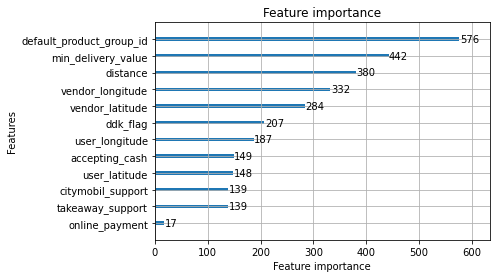

In [40]:
lgb.plot_importance(model)

### ALS

In [41]:
params = {
    'n_components': 100,
    'bm25_params': {
        'K1': 100,
        'B': 0.8,
    },
    'seed': 42,
    'scale': 100,
    'num_threads': 2,
    'num_iter': 10,
    'regularization': 1
}

def create_item_user_matrix(df, params):
    data = df[['customer_id', 'chain_id', 'target']].copy()
    
    unique_rows = list(np.unique(data['customer_id']).astype(np.int32))
    unique_cols = list(np.unique(data['chain_id']).astype(np.int32))

    row_map = dict(zip(unique_rows, range(len(unique_rows))))
    col_map = dict(zip(unique_cols, range(len(unique_cols))))

    data['customer_id'] = data['customer_id'].map(row_map)
    data['chain_id'] = data['chain_id'].map(col_map)

    matrix = csr_matrix((data['target'], [data['customer_id'], data['chain_id']]))
    matrix = bm25_weight(matrix, **params['bm25_params']).T.tocsr() * params['scale']
    
    return matrix

def compute_als_decomposition(matrix, params):
    np.random.seed(params['seed'])
    implicit_als = implicit.als.AlternatingLeastSquares(
        params['n_components'], num_threads=params['num_threads'], iterations=params['num_iter'],
        regularization=params['regularization']
    )
    implicit_als.fit(matrix)

    return implicit_als

In [42]:
previous_fold = pairs.loc[folds['previous']].groupby(['customer_id', 'chain_id'])['target'].max().reset_index()
prev_matrix = create_item_user_matrix(previous_fold, params)

train_m, val_m = train_test_split(prev_matrix, 0.7)

In [43]:
implicit_als = compute_als_decomposition(train_m, params)

In [44]:
precision_at_k(implicit_als, train_m.T, val_m.T, K=15)

0.07463876586266673

In [45]:
ndcg_at_k(implicit_als, train_m.T, val_m.T)

0.044341897295772356